# Pandas IV - Data Ops 2 [Group]

# <font color = 'green'>1. The GroupBy mechanics:</font>
## <font color = 'blue'>1.1. The GroupBy mechanics: Basics</font>

Each grouping key can take many forms, and the keys do not have to be all of the
same type:
  - A list or array of values that is the same length as the axis being grouped
  - A value indicating a column name in a DataFrame
  - A dict or Series giving a correspondence between the values on the axis being grouped and the group names
  - A function to be invoked on the axis index or the individual labels in the index

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'], 
                   'key2' : ['one', 'two', 'one', 'two', 'one'], 
                   'data1' : np.random.randn(5), 
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.417218,0.897748
1,a,two,-0.675430,1.042986
2,b,one,1.061757,1.243346
3,b,two,0.260503,-1.281297
4,a,one,0.013888,0.632165


In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [4]:
grouped.sum()

key1
a   -0.244324
b    1.322261
Name: data1, dtype: float64

In [5]:
# Using the general aggregation method:
grouped.agg('sum')

key1
a   -0.244324
b    1.322261
Name: data1, dtype: float64

In [6]:
grouped.mean()

key1
a   -0.081441
b    0.661130
Name: data1, dtype: float64

The important
thing here is that the data (a Series) has been aggregated according to the group key,
producing a new Series that is now indexed by the unique values in the key1 column.
The result index has the name <code>'key1'</code> because the DataFrame column <code>df['key1']</code>
did.
If instead we had passed multiple arrays as a list, we’d get something different:

In [7]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.215553
      two    -0.675430
b     one     1.061757
      two     0.260503
Name: data1, dtype: float64

In [8]:
# Here we grouped the data using two keys, and the resulting Series now has a hierarchical index consisting of the unique pairs of keys observed:
means.unstack()

key2,one,two
key1,,
a,0.215553,-0.675430
b,1.061757,0.260503


In [9]:
# The Group keys don't have to exist in the DataFrame,the can be a list or array of values that is the same length as the axis being grouped.
states = np.array(['Maharashtra', 'Karnataka', 'Karnataka', 'Maharashtra', 'Maharashtra'])
years = np.array([2005, 2005, 2006, 2006, 2007])
df['data1'].groupby([states, years]).mean()

Karnataka    2005   -0.675430
             2006    1.061757
Maharashtra  2005    0.417218
             2006    0.260503
             2007    0.013888
Name: data1, dtype: float64

In [10]:
df.loc[:, 'data1':'data2'].groupby([states, years]).mean()

data1     data2
Karnataka   2005 -0.675430  1.042986
            2006  1.061757  1.243346
Maharashtra 2005  0.417218  0.897748
            2006  0.260503 -1.281297
            2007  0.013888  0.632165

In [11]:
df.groupby([states, years]).mean()

data1     data2
Karnataka   2005 -0.675430  1.042986
            2006  1.061757  1.243346
Maharashtra 2005  0.417218  0.897748
            2006  0.260503 -1.281297
            2007  0.013888  0.632165

In [12]:
#Frequently the grouping information is found in the same DataFrame as the data you want to work on. In that case, you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.081441,0.857633
b,0.661130,-0.018976


In [13]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.215553  0.764956
     two  -0.675430  1.042986
b    one   1.061757  1.243346
     two   0.260503 -1.281297

## Note:
You may have noticed in the first case <code>df.groupby('key1').mean()</code> that there is no
key2 column in the result. Because <code>df['key2']</code> is not numeric data, it is said to be a
nuisance column, which is therefore excluded from the result. By default, all of the
numeric columns are aggregated, though it is possible to filter down to a subset, as
you’ll see soon.

In [14]:
# Regardless of the objective in using groupby, a generally useful GroupBy method is size, which returns a Series containing group sizes:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

## <font color = 'blue'>1.2. Selecting columns</font>
Indexing a GroupBy object created from a DataFrame with a column name or array
of column names has the effect of column subsetting for aggregation. This means
that:

    df.groupby('key1')['data1']
    df.groupby('key1')[['data2']]
    
are syntactic sugar for:

    df['data1'].groupby(df['key1'])
    df[['data2']].groupby(df['key1'])

Especially for large datasets, it may be desirable to aggregate only a few columns. For
example, in the preceding dataset, to compute means for just the <code>data2</code> column and
get the result as a **DataFrame**, we could write:

In [15]:
df_grouped = df.groupby(['key1', 'key2'])[['data2']].mean()
df_grouped

data2
key1 key2          
a    one   0.764956
     two   1.042986
b    one   1.243346
     two  -1.281297

The object returned by this indexing operation is:
 - a <code>grouped DataFrame</code> if a list or array is passed or 
 - a <code>grouped Series</code> if only a single column name is passed as a scalar:

In [16]:
s_grouped = df.groupby(['key1', 'key2'])['data2'].mean()
s_grouped

key1  key2
a     one     0.764956
      two     1.042986
b     one     1.243346
      two    -1.281297
Name: data2, dtype: float64

## <font color = 'blue'>1.3. Grouping by Dicts and Series</font>

In [17]:
# Program to generate a m x n DataFrame with random NaN values scattered in:
import random
def df_maker(m, n): 
    df = pd.DataFrame(np.random.randint(1, 100, (m*n)).reshape(m, n), index = [f'Row {i+1}' for i in range(m)], columns = [f'Col {j+1}' for j in range(n)] )
    for i in range(m):
        df.iloc[[i],[random.randrange(n)]] = np.nan
    return df
df = df_maker(10, 10) 
df.index.name = 'Rows'
df.columns.name = 'Columns'
df

Columns,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,Col 10
Rows,,,,,,,,,,
Row 1,34.0,9.0,27,14.0,77,NaN,77,20.0,35,80
Row 2,84.0,91.0,24,20.0,57,NaN,13,86.0,89,79
Row 3,53.0,NaN,7,38.0,41,71.0,15,29.0,8,40
Row 4,NaN,50.0,31,26.0,5,38.0,15,91.0,5,16
Row 5,49.0,52.0,54,NaN,41,95.0,47,21.0,43,76
Row 6,10.0,3.0,31,37.0,8,25.0,57,NaN,16,51
Row 7,28.0,59.0,45,NaN,70,38.0,87,61.0,26,83
Row 8,NaN,52.0,98,82.0,56,3.0,10,62.0,97,48
Row 9,89.0,89.0,32,NaN,96,63.0,85,77.0,30,47


In [18]:
# Program to generate a m x n DataFrame with random NaN values scattered in, this time using the pd.Index object properties:
import random
def df_maker(m, n):
    index = pd.Index([f'Row {i + 1}' for i in range(m)], name='Rows')
    columns = pd.Index([f'Col {i + 1}' for i in range(n)], name='Columns')
    df = pd.DataFrame(np.random.randint(1, 100, size=(m, n)), index=index, columns=columns)
    for i in range(m):
        df.iloc[[i],[random.randrange(n)]] = np.nan
    return df
df = df_maker(5, 5) 
df

Columns,Col 1,Col 2,Col 3,Col 4,Col 5
Rows,,,,,
Row 1,7,75,NaN,78,22.0
Row 2,65,98,62.0,34,NaN
Row 3,71,67,12.0,49,NaN
Row 4,12,38,NaN,81,87.0
Row 5,51,23,NaN,68,57.0


In [19]:
# Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:
mapping = {'Col 1': 'Group 1', 'Col 2': 'Group 1', 'Col 3': 'Group 2', 'Col 4': 'Group 1', 'Col 5': 'Group 2', }

# Now, you could construct an array from this dict to pass to groupby():
s = pd.Series(mapping)

# passing the series to group all the columns by the given mapping:
df.groupby([s], axis = 1).mean().round(2)

,Group 1,Group 2
Rows,,
Row 1,53.33,22.0
Row 2,65.67,62.0
Row 3,62.33,12.0
Row 4,43.67,87.0
Row 5,47.33,57.0


In [20]:
# We could directly pass the group key (the dict in this case) to the groupby() function:
mapping = {'Col 1': 'Group 1', 'Col 2': 'Group 1', 'Col 3': 'Group 2', 'Col 4': 'Group 1', 'Col 5': 'Group 2', 'Col 6': 'Group 2', }
# Note the unused group keys:
df.groupby(mapping, axis = 1).mean().round()

,Group 1,Group 2
Rows,,
Row 1,53.0,22.0
Row 2,66.0,62.0
Row 3,62.0,12.0
Row 4,44.0,87.0
Row 5,47.0,57.0


## <font color = 'blue'>1.4. Grouping by Functions</font>
#### <font color = 'red'>Need Examples Here</font>

## <font color = 'blue'>Grouping by Index Levels</font>
A final convenience for hierarchically indexed datasets is the ability to aggregate
using one of the levels of an axis index. Let’s look at an example:

In [21]:
columns = pd.MultiIndex.from_arrays([['Student 1', 'Student 1', 'Student 1', 'Student 2', 'Student 2', 'Student 2'], ['Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math']], names=['Student', 'Subject'])
index = pd.Index([2016, 2017, 2018, 2019], name = 'Year')
marks = pd.DataFrame(np.random.randint(50, 100, 24).reshape(4, 6), index = index, columns = columns)
marks                                                                       

Student Student 1                Student 2               
Subject   Physics Chemistry Math   Physics Chemistry Math
Year                                                     
2016           60        81   50        88        63   89
2017           91        92   98        92        71   86
2018           92        78   52        73        84   61
2019           90        65   93        55        78   74

In [22]:
marks.groupby(level = 'Subject', axis = 1).mean()

Subject,Chemistry,Math,Physics
Year,,,
2016,72.0,69.5,74.0
2017,81.5,92.0,91.5
2018,81.0,56.5,82.5
2019,71.5,83.5,72.5


In [23]:
marks.groupby(level = 'Student', axis = 1).mean().round(2)

Student,Student 1,Student 2
Year,,
2016,63.67,80.00
2017,93.67,83.00
2018,74.00,72.67
2019,82.67,69.00


# <font color = 'green'>2. Data Aggregation with GroupBy: <code>agg()</code></font>

## <font color = 'blue'>2.1. The <code>agg()</code> Function </font>

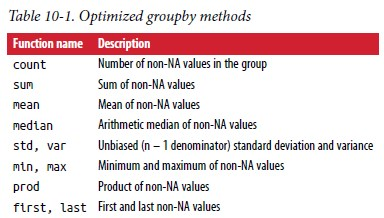

In [24]:
tips = pd.read_csv('tips.csv')
tips.head()

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4


In [25]:
tips.shape

(244, 6)

In [26]:
tips['tip_pct'] = (tips['tip'] / tips['total_bill']*100).round(2)
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,5.94
1,10.34,1.66,No,Sun,Dinner,3,16.05
2,21.01,3.50,No,Sun,Dinner,3,16.66
3,23.68,3.31,No,Sun,Dinner,2,13.98
4,24.59,3.61,No,Sun,Dinner,4,14.68


In [27]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
tip_pct       244 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 13.5+ KB


In [28]:
tips.describe(include = 'all').round(2)

,total_bill,tip,smoker,day,time,size,tip_pct
count,244.00,244.00,244,244,244,244.00,244.00
unique,NaN,NaN,2,4,2,NaN,NaN
top,NaN,NaN,No,Sat,Dinner,NaN,NaN
freq,NaN,NaN,151,87,176,NaN,NaN
mean,19.79,3.00,NaN,NaN,NaN,2.57,16.08
std,8.90,1.38,NaN,NaN,NaN,0.95,6.11
min,3.07,1.00,NaN,NaN,NaN,1.00,3.56
25%,13.35,2.00,NaN,NaN,NaN,2.00,12.91
50%,17.80,2.90,NaN,NaN,NaN,2.00,15.48
75%,24.13,3.56,NaN,NaN,NaN,3.00,19.15


In [29]:
tips['day'].unique().tolist()

['Sun', 'Sat', 'Thur', 'Fri']

In [30]:
# Create groupby object:
tips_grouped = tips.groupby(['day', 'smoker'])

In [31]:
# Return a dataframe, aggregate for group keys:
tips_grouped.agg('mean').round(2)

total_bill   tip  size  tip_pct
day  smoker                                 
Fri  No           18.42  2.81  2.25    15.16
     Yes          16.81  2.71  2.07    17.48
Sat  No           19.66  3.10  2.56    15.80
     Yes          21.28  2.88  2.48    14.79
Sun  No           20.51  3.17  2.93    16.01
     Yes          24.12  3.52  2.58    18.72
Thur No           17.11  2.67  2.49    16.03
     Yes          19.19  3.03  2.35    16.39

In [32]:
# Note that for descriptive statistics like those in Table 10-1, you can pass the name of the function as a string
grouped_pct = tips_grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        15.165000
      Yes       17.478667
Sat   No        15.804222
      Yes       14.790000
Sun   No        16.011228
      Yes       18.724737
Thur  No        16.028667
      Yes       16.385294
Name: tip_pct, dtype: float64

In [33]:
# If you pass a list of functions or function names instead, you get back a DataFrame with column names taken from the functions:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean        std  peak_to_peak
day  smoker                                    
Fri  No      15.165000   2.809703          6.73
     Yes     17.478667   5.129855         15.99
Sat  No      15.804222   3.976763         23.52
     Yes     14.790000   6.137342         29.01
Sun  No      16.011228   4.234462         19.33
     Yes     18.724737  15.412702         64.46
Thur No      16.028667   3.876920         19.33
     Yes     16.385294   3.939388         15.13

You don’t need to accept the names that GroupBy gives to the columns; notably,
lambda functions have the name <code>lambda</code>, which makes them hard to identify
(you can see for yourself by looking at a function’s __name__ attribute). Thus, if you
pass a list of (name, function) tuples, the first element of each tuple will be used as
the DataFrame column names (you can think of a list of 2-tuples as an ordered
mapping):

In [34]:
grouped_pct.agg([('Mean', 'mean'), ('Std. Dev.', 'std'), ('Range', peak_to_peak)])

Mean  Std. Dev.  Range
day  smoker                             
Fri  No      15.165000   2.809703   6.73
     Yes     17.478667   5.129855  15.99
Sat  No      15.804222   3.976763  23.52
     Yes     14.790000   6.137342  29.01
Sun  No      16.011228   4.234462  19.33
     Yes     18.724737  15.412702  64.46
Thur No      16.028667   3.876920  19.33
     Yes     16.385294   3.939388  15.13

With a DataFrame you have more options, as you can specify a list of functions to
apply to all of the columns or different functions per column. To start, suppose we
wanted to compute the same three statistics for the <code>tip_pct</code> and <code>total_bill</code>
columns:

In [35]:
functions = ['count', 'mean', 'max']
result = tips_grouped['total_bill', 'tip_pct'].agg(functions).round(2)
result

total_bill               tip_pct              
                 count   mean    max   count   mean    max
day  smoker                                               
Fri  No              4  18.42  22.75       4  15.16  18.77
     Yes            15  16.81  40.17      15  17.48  26.35
Sat  No             45  19.66  48.33      45  15.80  29.20
     Yes            42  21.28  50.81      42  14.79  32.57
Sun  No             57  20.51  48.17      57  16.01  25.27
     Yes            19  24.12  45.35      19  18.72  71.03
Thur No             45  17.11  41.19      45  16.03  26.63
     Yes            17  19.19  43.11      17  16.39  24.13

In [36]:
# As you can see, the resulting DataFrame has hierarchical columns, the same as you would get aggregating each column separately and using concat to glue the results together using the column names as the keys argument:
result['tip_pct']

count   mean    max
day  smoker                     
Fri  No          4  15.16  18.77
     Yes        15  17.48  26.35
Sat  No         45  15.80  29.20
     Yes        42  14.79  32.57
Sun  No         57  16.01  25.27
     Yes        19  18.72  71.03
Thur No         45  16.03  26.63
     Yes        17  16.39  24.13

In [37]:
# As before, a list of tuples with custom names can be passed:
ftuples = [('Count', 'count'), ('Mean', 'mean'), ('Variance', 'var')]
result = tips_grouped['total_bill', 'tip_pct'].agg(ftuples).round(2)
result

total_bill                 tip_pct                
                 Count   Mean Variance   Count   Mean Variance
day  smoker                                                   
Fri  No              4  18.42    25.60       4  15.16     7.89
     Yes            15  16.81    82.56      15  17.48    26.32
Sat  No             45  19.66    79.91      45  15.80    15.81
     Yes            42  21.28   101.39      42  14.79    37.67
Sun  No             57  20.51    66.10      57  16.01    17.93
     Yes            19  24.12   109.05      19  18.72   237.55
Thur No             45  17.11    59.63      45  16.03    15.03
     Yes            17  19.19    69.81      17  16.39    15.52

In [38]:
# Now, suppose you wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to agg that contains a mapping of column names to any of the function specifications listed so far:

# Remember: tips_grouped = tips.groupby(['day', 'smoker'])

# Create the mapping of functions to different columns:
mapping = {'tip' : np.max, 'size' : 'sum'}

# pass the mapping dict:
result = tips_grouped.agg(mapping)
result

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [39]:
# A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column.

mapping = {'size' : 'sum', 'tip':['min', 'max', 'mean', 'std']}
result = tips_grouped.agg(mapping).round(2)
result

size   tip                   
             sum   min    max  mean   std
day  smoker                              
Fri  No        9  1.50   3.50  2.81  0.90
     Yes      31  1.00   4.73  2.71  1.08
Sat  No      115  1.00   9.00  3.10  1.64
     Yes     104  1.00  10.00  2.88  1.63
Sun  No      167  1.01   6.00  3.17  1.22
     Yes      49  1.50   6.50  3.52  1.26
Thur No      112  1.25   6.70  2.67  1.28
     Yes      40  2.00   5.00  3.03  1.11

## <font color = 'blue'>2.2. Returning Aggregated Data Without Row Indexes </font>
In all of the examples up until now, the aggregated data comes back with an index,
potentially hierarchical, composed from the unique group key combinations. Since
this isn’t always desirable, you can disable this behavior in most cases by passing
<code>as_index=False</code> to <code>groupby</code>:

In [40]:
tips.groupby(['day', 'smoker'], as_index=False).mean().round(2)

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.42,2.81,2.25,15.16
1,Fri,Yes,16.81,2.71,2.07,17.48
2,Sat,No,19.66,3.10,2.56,15.80
3,Sat,Yes,21.28,2.88,2.48,14.79
4,Sun,No,20.51,3.17,2.93,16.01
5,Sun,Yes,24.12,3.52,2.58,18.72
6,Thur,No,17.11,2.67,2.49,16.03
7,Thur,Yes,19.19,3.03,2.35,16.39


# <font color = 'green'>3. General split-apply-combine: <code>apply()</code></font>

## <font color = 'blue'>3.1 The <code>apply()</code> function</font>

The most general-purpose GroupBy method is <code>apply()</code>, which is the subject of the rest
of this section. As illustrated in Figure 10-2, apply splits the object being manipulated
into pieces, invokes the passed function on each piece, and then attempts to concatenate
the pieces together.

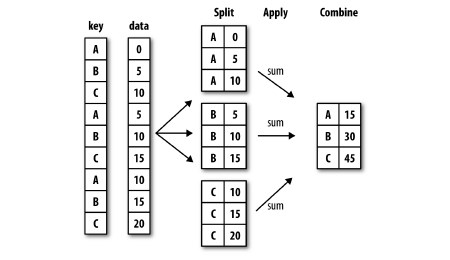

Returning to the tipping dataset from before, suppose you wanted to select the top
five <code>tip_pct</code> values by group. First, write a function that selects the rows with the
largest values in a particular column:

In [41]:
tips_grouped = tips.groupby(['day', 'smoker'])

def top_pct(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

top_pct(tips, n = 6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,27.95
183,23.17,6.50,Yes,Sun,Dinner,4,28.05
232,11.61,3.39,No,Sat,Dinner,2,29.20
67,3.07,1.00,Yes,Sat,Dinner,1,32.57
178,9.60,4.00,Yes,Sun,Dinner,2,41.67
172,7.25,5.15,Yes,Sun,Dinner,2,71.03


In [42]:
# Now, if we group by smoker, say, and call apply with this function, we get the following:
tips.groupby('smoker').apply(top_pct)

total_bill   tip smoker   day    time  size  tip_pct
smoker                                                          
No     88        24.71  5.85     No  Thur   Lunch     2    23.67
       185       20.69  5.00     No   Sun  Dinner     5    24.17
       51        10.29  2.60     No   Sun  Dinner     2    25.27
       149        7.51  2.00     No  Thur   Lunch     2    26.63
       232       11.61  3.39     No   Sat  Dinner     2    29.20
Yes    109       14.31  4.00    Yes   Sat  Dinner     2    27.95
       183       23.17  6.50    Yes   Sun  Dinner     4    28.05
       67         3.07  1.00    Yes   Sat  Dinner     1    32.57
       178        9.60  4.00    Yes   Sun  Dinner     2    41.67
       172        7.25  5.15    Yes   Sun  Dinner     2    71.03

What has happened here? The <code>top_pct</code> function is called on each row group from the
DataFrame, and then the results are glued together using <code>pandas.concat</code>, labeling the
pieces with the group names. The result therefore has a hierarchical index whose
inner level contains index values from the original DataFrame.

If you pass a function to <code>apply</code> that takes other arguments or keywords, you can pass
these after the function:

In [43]:
tips_grouped = tips.groupby(['day', 'smoker'])

def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size  tip_pct
smoker day                                                            
No     Fri  94        22.75   3.25     No   Fri  Dinner     2    14.29
       Sat  212       48.33   9.00     No   Sat  Dinner     4    18.62
       Sun  156       48.17   5.00     No   Sun  Dinner     6    10.38
       Thur 142       41.19   5.00     No  Thur   Lunch     5    12.14
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4    11.77
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3    19.68
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3     7.72
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4    11.60

You may recall that I earlier called <code>describe</code> on a GroupBy object:

In [44]:
result = tips.groupby('smoker')['tip_pct'].describe().round(2)
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,15.93,3.99,5.68,13.69,15.56,18.50,29.20
Yes,93.0,16.32,8.51,3.56,10.68,15.38,19.51,71.03


In [45]:
result.unstack()

       smoker
count  No        151.00
       Yes        93.00
mean   No         15.93
       Yes        16.32
std    No          3.99
       Yes         8.51
min    No          5.68
       Yes         3.56
25%    No         13.69
       Yes        10.68
50%    No         15.56
       Yes        15.38
75%    No         18.50
       Yes        19.51
max    No         29.20
       Yes        71.03
dtype: float64

In [46]:
# Inside GroupBy, when you invoke a method like describe, it is actually just a shortcut for:

f = lambda x: x.describe().round(2)
grouped.apply(f)

key1       
a     count    3.00
      mean    -0.08
      std      0.55
      min     -0.68
      25%     -0.33
      50%      0.01
      75%      0.22
      max      0.42
b     count    2.00
      mean     0.66
      std      0.57
      min      0.26
      25%      0.46
      50%      0.66
      75%      0.86
      max      1.06
Name: data1, dtype: float64

## <font color = 'blue'>3.2 GroupBy: Quantile and Bucket Analysis</font>
pandas has some tools, in particular cut and qcut,
for slicing data up into buckets with bins of your choosing or by sample quantiles.
Combining these functions with groupby makes it convenient to perform bucket or
quantile analysis on a dataset. Consider the tips dataset and an equal-length
bucket categorization using <code>cut</code>:

In [47]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,5.94
1,10.34,1.66,No,Sun,Dinner,3,16.05
2,21.01,3.50,No,Sun,Dinner,3,16.66
3,23.68,3.31,No,Sun,Dinner,2,13.98
4,24.59,3.61,No,Sun,Dinner,4,14.68


Tip_pct Desciption:
Tip_pct(min) : 3.56
Q1     : 12.91
Q2     : 15.475
Q3     : 19.1475
Tip_pct(max) : 71.03


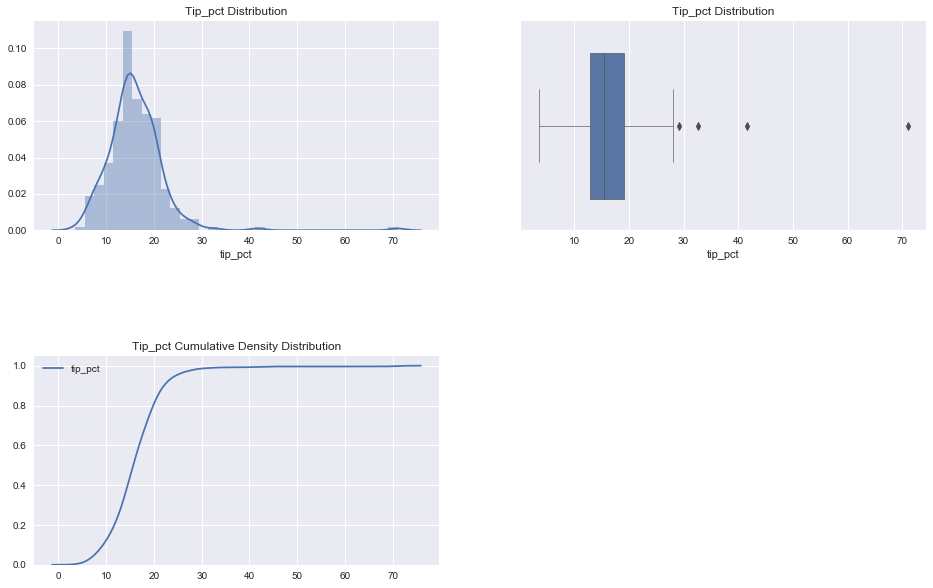

In [48]:
data = tips
def summary(x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    print(f'{x.capitalize()} Desciption:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1     : {Q1}\n'
          f'Q2     : {Q2}\n'
          f'Q3     : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}')

    fig = plt.figure(figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.6)
    plt.subplot(221)
    ax1 = sns.distplot(data[x])
    plt.title(f'{x.capitalize()} Distribution')
    plt.subplot(222)
    ax2 = sns.boxplot(x=data[x], width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Distribution')
    plt.subplot(223)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    plt.show()
    
summary('tip_pct')

In [49]:
quartiles = pd.qcut(tips.tip_pct, 4, labels = ['Low', 'Medium', 'High', 'Very High'])
quartiles[:5]

0       Low
1      High
2      High
3    Medium
4    Medium
Name: tip_pct, dtype: category
Categories (4, object): [Low < Medium < High < Very High]

In [50]:
pd.value_counts(quartiles)

Very High    61
High         61
Medium       61
Low          61
Name: tip_pct, dtype: int64

The Categorical object returned by cut can be passed directly to <code>groupby</code>. So we could compute a set of statistics for the data2 column like so:

In [51]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = tips['tip_pct'].groupby(quartiles)
grouped.apply(get_stats).round(2)

tip_pct         
Low        min       3.56
           max      12.82
           count    61.00
           mean      9.90
Medium     min      12.94
           max      15.43
           count    61.00
           mean     14.33
High       min      15.52
           max      19.12
           count    61.00
           mean     17.15
Very High  min      19.23
           max      71.03
           count    61.00
           mean     22.94
Name: tip_pct, dtype: float64